# Encode graph's edges into a Wave-Function

### Load the Libraries needed

In [1]:
import json                       # Read and write files in json
import numpy as np                # Matrix operations
import qiskit as q
import qiskit_aqua as qa
from pprint import pprint         # Pretty printing of matrices
from math import log2, ceil, floor

# Load the Graph and make it Unweighted

In [2]:
file_path = "test_graph.json"

In [3]:
with open(file_path, "r") as f:
    graph = json.load(f)
pprint(graph)

[[[1, 0.901], [2, 0.464], [3, 0.197]],
 [[0, 0.901], [2, 0.416], [4, 0.94], [5, 0.665]],
 [[0, 0.464], [1, 0.416], [3, 0.05], [6, 0.224]],
 [[0, 0.197], [2, 0.05], [4, 0.57], [6, 0.028]],
 [[1, 0.94], [3, 0.57], [5, 0.898], [6, 0.931]],
 [[1, 0.665], [4, 0.898]],
 [[2, 0.224], [3, 0.028], [4, 0.931]]]


In [4]:
n_of_vertices = len(graph)

In [5]:
# Convert the graph in a list of triples in the form (start, end, weight)
graph = [(start, v[0]) for start, value in enumerate(graph) for v in value]
pprint(graph)

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 2),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 6),
 (3, 0),
 (3, 2),
 (3, 4),
 (3, 6),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 6),
 (5, 1),
 (5, 4),
 (6, 2),
 (6, 3),
 (6, 4)]


# Initialize the Qbits registers and their subsets

In [6]:
n_of_bits = ceil(log2(max((e[0] for e in graph))))
print("To encode the edges we need %d qbits per nodes"%n_of_bits)

To encode the edges we need 3 qbits per nodes


In [7]:
start = q.QuantumRegister(n_of_bits, name="s")
end = q.QuantumRegister(n_of_bits, name ="e")
membership = q.QuantumRegister(1, name ="m")

In [8]:
# We will and in a tree fashion the values so we need and in a tree with n leafes we have n-1 internal nodes
aux_dim = 2*n_of_bits - 1
aux = q.QuantumRegister(aux_dim, name="a")

In [9]:
reg = [v for register in [start,end] for v in register]
reg_dim = len(reg)

In [10]:
qbits = [v for register in [start,end,aux] for v in register]
n_of_total_qbits = len(qbits)

In [11]:
all_qbits = [v for register in [start,end,aux,membership] for v in register]
n_of_all_qbits = len(qbits)

# Create the Circuit

In [12]:
circuit = q.QuantumCircuit(start, end, aux, membership)

# Initialize the edge qbits with an Hadamard gate

In [13]:
for r in reg:
    circuit.h(r)

In [14]:
# Print the circuit
circuit.draw(output="mpl")

<Figure size 334.444x1028.42 with 1 Axes>

# State encode the edge as the concatenation of the binary rappresentation of the nodes

In [15]:
edge_binary_encoding = ["{:03b}".format(e[0]) + "{:03b}".format(e[1]) for e in graph]
pprint(edge_binary_encoding)
print("# of edges %d"%n_of_vertices)

['000001',
 '000010',
 '000011',
 '001000',
 '001010',
 '001100',
 '001101',
 '010000',
 '010001',
 '010011',
 '010110',
 '011000',
 '011010',
 '011100',
 '011110',
 '100001',
 '100011',
 '100101',
 '100110',
 '101001',
 '101100',
 '110010',
 '110011',
 '110100']
# of edges 7


# Create the Superposition that have all states with equal probability but with the one which are edges have negative phase

In [16]:
def encode_edge(circuit, edge):
    circuit.barrier()
    ###################################################################
    # Setup
    ###################################################################
    # Add nots if the qbit must be 0 since we have to do an AND
    for i, b in enumerate(edge):
        if b == '0':
            circuit.x(reg[i])
            
    ###################################################################
    # And of all qbits
    ###################################################################
            
    # And togheather the aux qbits
    and_index = 0
    result_index = ceil(n_of_total_qbits/2)
    
    while and_index < result_index-1:
        circuit.ccx(qbits[and_index],qbits[and_index+1], qbits[result_index])
        and_index += 2
        result_index += 1

    ###################################################################
    # Phase change
    ###################################################################
    
    circuit.cx(aux[len(aux)-1], membership[0])
    
    ###################################################################
    # Clean the qbits
    ###################################################################
    
    # Clear the values
    and_index = n_of_total_qbits - 3
    result_index = n_of_total_qbits - 1
    
    while and_index >= 0:
        circuit.ccx(qbits[and_index],qbits[and_index+1], qbits[result_index])
        and_index -= 2
        result_index -= 1
    
    ###################################################################
    # Reverse the Setup
    ###################################################################
    
    # Add nots if the qbit must be 0 since we have to do an AND
    for i, b in enumerate(edge):
        if b == '0':
            circuit.x(reg[i])
            
    return circuit

In [17]:
circuit = encode_edge(circuit, edge_binary_encoding[0])

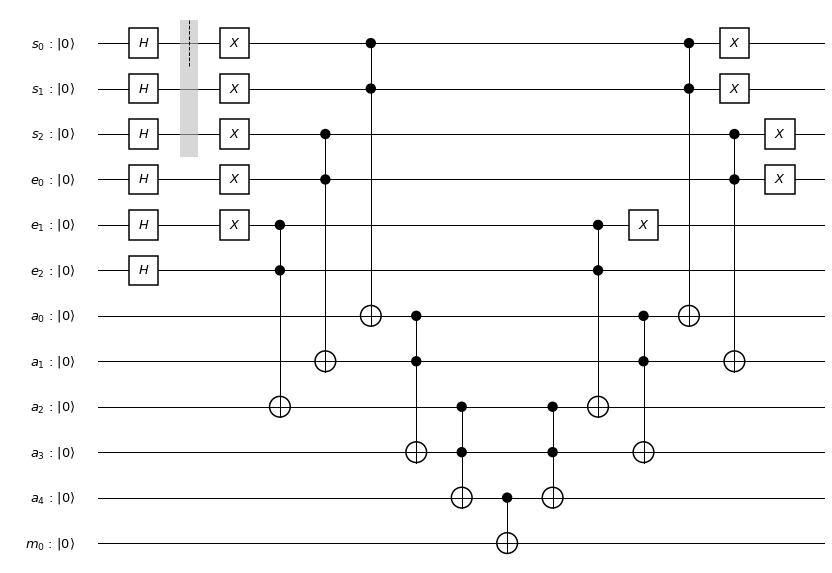

In [18]:
circuit.draw(output="mpl")

In [19]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 28
Depth 11


In [20]:
for edge in edge_binary_encoding[1:]:
    circuit = encode_edge(circuit, edge)

 # Print the Result

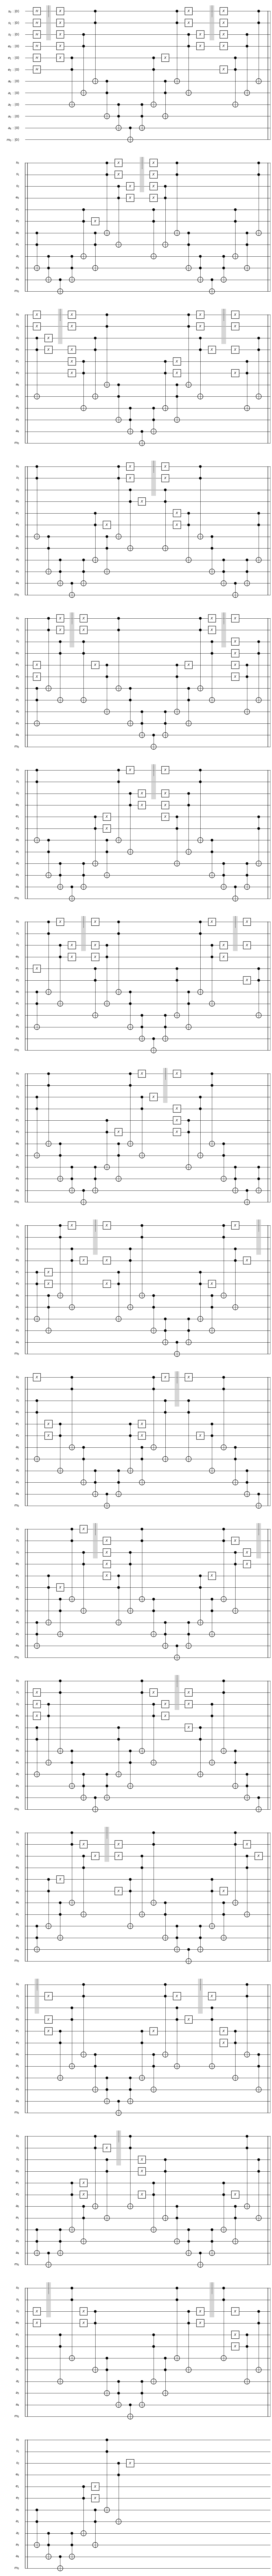

In [21]:
circuit.draw(output="mpl")

In [22]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 462
Depth 241


# Oracle

In [23]:
circuit.z(membership[0])

# Simulate the circuit Symbolically to get the wave-function 

In [24]:
def rotate_encoding(value):
    return "".join(list(reversed("{:012b}".format(value))))

In [25]:
backend_sim = q.BasicAer.get_backend('statevector_simulator')
result = q.execute(circuit, backend_sim).result()

for index, value in enumerate(result.get_statevector(circuit)):
    if abs(value) > 0:
        print("({:+4f} + {:+4f}) |{}> P = {:4f}".format(value.real, value.imag, rotate_encoding(index), abs(value)))

(+0.125000 + -0.000000) |000000000000> P = 0.125000
(+0.125000 + -0.000000) |100000000000> P = 0.125000
(+0.125000 + -0.000000) |110000000000> P = 0.125000
(+0.125000 + -0.000000) |101000000000> P = 0.125000
(+0.125000 + -0.000000) |111000000000> P = 0.125000
(+0.125000 + -0.000000) |000100000000> P = 0.125000
(+0.125000 + -0.000000) |100100000000> P = 0.125000
(+0.125000 + -0.000000) |010100000000> P = 0.125000
(+0.125000 + -0.000000) |111100000000> P = 0.125000
(+0.125000 + -0.000000) |100010000000> P = 0.125000
(+0.125000 + -0.000000) |010010000000> P = 0.125000
(+0.125000 + -0.000000) |101010000000> P = 0.125000
(+0.125000 + -0.000000) |111010000000> P = 0.125000
(+0.125000 + -0.000000) |000110000000> P = 0.125000
(+0.125000 + -0.000000) |110110000000> P = 0.125000
(+0.125000 + -0.000000) |001110000000> P = 0.125000
(+0.125000 + -0.000000) |101110000000> P = 0.125000
(+0.125000 + -0.000000) |111110000000> P = 0.125000
(+0.125000 + -0.000000) |110001000000> P = 0.125000
(+0.125000 +

# Grover's Iteration

In [26]:
def grover_step(circuit):
    circuit.barrier()
    ###################################################################
    # H Col
    ###################################################################
    for r in all_qbits:
        circuit.h(r)
    ###################################################################
    # X Col
    ###################################################################
    # Add nots if the qbit must be 0 since we have to do an AND
    for r in all_qbits:
        circuit.x(r)

    ###################################################################
    # And of all qbits
    ###################################################################

    # And togheather the aux qbits
    and_index = 0
    result_index = ceil(n_of_total_qbits/2)

    while and_index < result_index-1:
        circuit.ccx(all_qbits[and_index],all_qbits[and_index+1], all_qbits[result_index])
        and_index += 2
        result_index += 1

    ###################################################################
    # Phase change
    ###################################################################

    circuit.x(membership[0])
    circuit.cz(aux[len(aux)-1], membership[0])
    circuit.x(membership[0])

    ###################################################################
    # Clean the qbits
    ###################################################################

    # Clear the values
    and_index = n_of_all_qbits - 3
    result_index = n_of_all_qbits - 1

    while and_index >= 0:
        circuit.ccx(all_qbits[and_index],all_qbits[and_index+1], all_qbits[result_index])
        and_index -= 2
        result_index -= 1

    ###################################################################
    # X Col
    ###################################################################
    # Add nots if the qbit must be 0 since we have to do an AND
    for r in all_qbits:
        circuit.x(r)
    ###################################################################
    # H Col
    ###################################################################
    for r in all_qbits:
        circuit.h(r)

    return circuit

In [27]:
n_of_grover_iterations = (np.pi * np.sqrt((2**n_of_total_qbits)/n_of_vertices))/4
print("The value is: %f"%n_of_grover_iterations)
n_of_grover_iterations = int(np.ceil(n_of_grover_iterations))
print("The number of grover iteration is %d"%n_of_grover_iterations)

The value is: 13.434015
The number of grover iteration is 14


In [28]:
for _ in range(n_of_grover_iterations):
    circuit = grover_step(circuit)

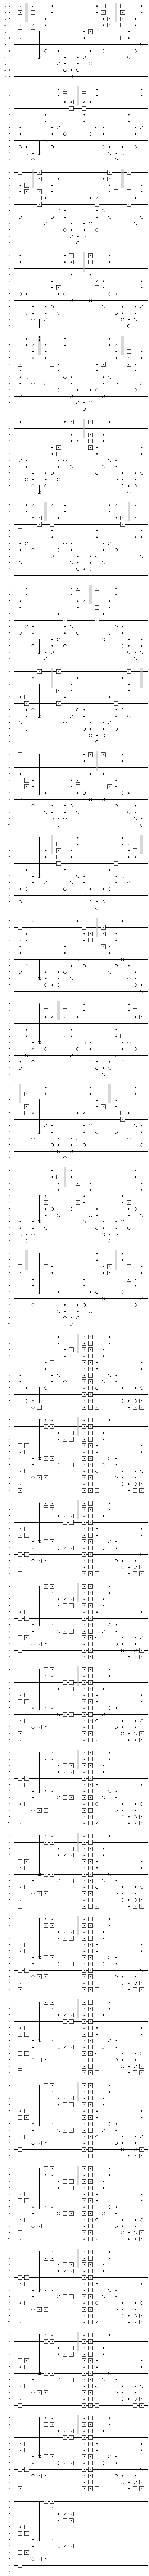

In [29]:
circuit.draw(output="mpl")

In [30]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 1331
Depth 409


# Simulate the circuit Symbolically to get the wave-function 

In [31]:
backend_sim = q.BasicAer.get_backend('statevector_simulator')
result = q.execute(circuit, backend_sim).result()

values = [(abs(value),"({:+4f} + {:+4f}) |{}> P = {:4f}".format(value.real, value.imag, rotate_encoding(index), abs(value))) for index, value in enumerate(result.get_statevector(circuit)) if abs(value) > 0.00001]

values.sort(key=lambda x: x[0], reverse=True)

for prob, string in values:
    print(string)

(+0.125000 + -0.000000) |111111000000> P = 0.125000
(-0.125000 + +0.000000) |000011000001> P = 0.125000
(+0.125000 + -0.000000) |110111000000> P = 0.125000
(+0.125000 + -0.000000) |110110000000> P = 0.125000
(+0.125000 + -0.000000) |111110000000> P = 0.125000
(+0.125000 + -0.000000) |110000000000> P = 0.125000
(+0.125000 + -0.000000) |101111000000> P = 0.125000
(+0.125000 + -0.000000) |011111000000> P = 0.125000
(+0.125000 + -0.000000) |111011000000> P = 0.125000
(+0.125000 + -0.000000) |111101000000> P = 0.125000
(+0.125000 + -0.000000) |101011000000> P = 0.125000
(+0.125000 + -0.000000) |111001000000> P = 0.125000
(+0.125000 + -0.000000) |010101000000> P = 0.125000
(+0.125000 + -0.000000) |110101000000> P = 0.125000
(-0.125000 + +0.000000) |011100000001> P = 0.125000
(-0.125000 + +0.000000) |101001000001> P = 0.125000
(+0.125000 + -0.000000) |101110000000> P = 0.125000
(+0.125000 + -0.000000) |101101000000> P = 0.125000
(+0.125000 + -0.000000) |001111000000> P = 0.125000
(+0.125000 +

# Measure the Output

In [32]:
cstart = q.ClassicalRegister(n_of_bits, 'cs')
cend   = q.ClassicalRegister(n_of_bits, 'ce')
circuit.add_register(cstart)
circuit.add_register(cend)

In [33]:
circuit.barrier()
circuit.measure(start, cstart)
circuit.measure(end, cend)

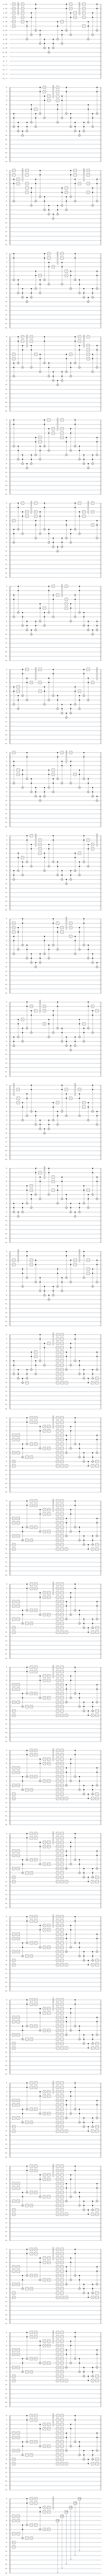

In [34]:
circuit.draw(output="mpl")

In [35]:
print("# of Gates %d"%circuit.size())
print("Depth %d"%circuit.depth())

# of Gates 1338
Depth 411


# Actually Simulate the computation 2^22 times

In [36]:
backend_sim = q.BasicAer.get_backend('qasm_simulator')
result = q.execute(circuit, backend_sim, shots=2**22).result()
counts = result.get_counts(circuit)
pprint(counts)

{'000 000': 64972,
 '000 001': 65854,
 '000 010': 65359,
 '000 011': 65902,
 '000 100': 65341,
 '000 101': 65620,
 '000 110': 65686,
 '000 111': 65516,
 '001 000': 65106,
 '001 001': 65386,
 '001 010': 65989,
 '001 011': 65725,
 '001 100': 66010,
 '001 101': 65399,
 '001 110': 65585,
 '001 111': 65836,
 '010 000': 65588,
 '010 001': 65789,
 '010 010': 65291,
 '010 011': 65478,
 '010 100': 65582,
 '010 101': 65178,
 '010 110': 65452,
 '010 111': 65597,
 '011 000': 65541,
 '011 001': 65482,
 '011 010': 65591,
 '011 011': 65671,
 '011 100': 65146,
 '011 101': 65844,
 '011 110': 65619,
 '011 111': 65720,
 '100 000': 65081,
 '100 001': 65239,
 '100 010': 65380,
 '100 011': 65509,
 '100 100': 64992,
 '100 101': 65985,
 '100 110': 65821,
 '100 111': 65678,
 '101 000': 65953,
 '101 001': 65646,
 '101 010': 65386,
 '101 011': 65540,
 '101 100': 65486,
 '101 101': 65849,
 '101 110': 65698,
 '101 111': 65404,
 '110 000': 65940,
 '110 001': 65219,
 '110 010': 65424,
 '110 011': 65488,
 '110 100': 

In [37]:
values = []
for key, item in counts.items():
    key = key.replace(" ","")
    works = key in edge_binary_encoding
    values.append((key,item, works))
    
values.sort(key=lambda x: -x[1])

for v in values:
    print("%s %02d %s"%v)
    

001100 66010 True
001010 65989 True
100101 65985 True
101000 65953 False
110000 65940 False
000011 65902 True
111000 65892 False
111010 65869 False
000001 65854 True
101101 65849 False
011101 65844 False
001111 65836 False
100110 65821 True
010001 65789 True
001011 65725 False
111011 65722 False
011111 65720 False
101110 65698 False
000110 65686 False
111111 65678 False
100111 65678 False
011011 65671 False
101001 65646 True
000101 65620 False
011110 65619 True
010111 65597 False
011010 65591 True
010000 65588 True
001110 65585 False
010100 65582 False
011000 65541 True
101011 65540 False
111110 65524 False
110100 65517 True
000111 65516 False
100011 65509 True
110011 65488 True
101100 65486 True
011001 65482 False
010011 65478 True
010110 65452 True
110010 65424 True
111001 65410 False
110101 65405 False
101111 65404 False
001101 65399 True
101010 65386 False
001001 65386 False
100010 65380 False
000010 65359 True
000100 65341 False
111100 65297 False
010010 65291 False
110111 65280 F